Device: cpu
Epoch 01:  Reg MSE  train 50114.9476 | test 2007.1133   ||  Cls ACC  train   9.0% | test   7.8%
Epoch 02:  Reg MSE  train 3212.3264 | test 3597.5122   ||  Cls ACC  train   5.5% | test   3.1%
Epoch 03:  Reg MSE  train 2490.3972 | test 230.5370   ||  Cls ACC  train   5.5% | test  23.4%
Epoch 04:  Reg MSE  train 279.4431 | test 475.7998   ||  Cls ACC  train   9.0% | test   6.2%
Epoch 05:  Reg MSE  train 413.6009 | test 115.5387   ||  Cls ACC  train   5.9% | test   4.7%
Epoch 06:  Reg MSE  train 130.5388 | test 187.7016   ||  Cls ACC  train   8.6% | test   6.2%
Epoch 07:  Reg MSE  train 175.1454 | test 166.7474   ||  Cls ACC  train   5.9% | test  12.5%
Epoch 08:  Reg MSE  train 143.4960 | test 108.8261   ||  Cls ACC  train  13.3% | test   9.4%
Epoch 09:  Reg MSE  train 111.6874 | test 103.7031   ||  Cls ACC  train  15.6% | test   3.1%
Epoch 10:  Reg MSE  train 115.4837 | test 97.3907   ||  Cls ACC  train   9.0% | test  14.1%
Epoch 11:  Reg MSE  train 112.9462 | test 94.1729   |

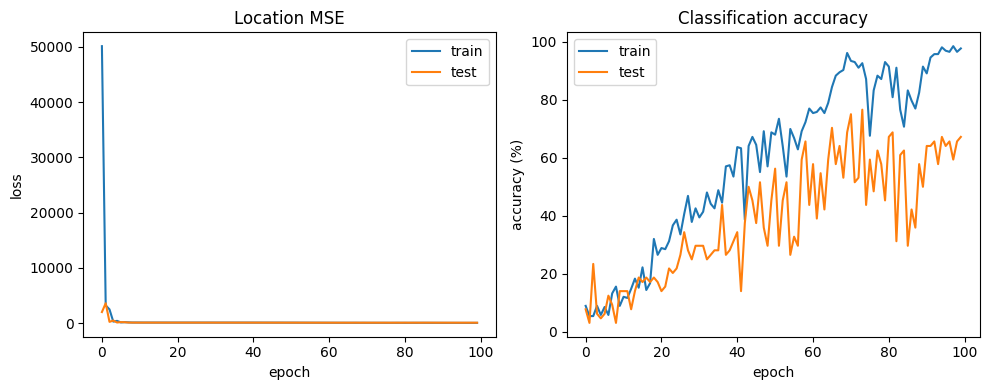

In [27]:
# ---------------------------------------------------------------
# 0.  Imports
# ---------------------------------------------------------------
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt, random


# make more reproducible
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------------------------------------------------------
# 1.  Load data  
# ---------------------------------------------------------------
X_train = np.load("X_test.npy")          # n x 9 (histograms) x 128 (bins)
Y_train = np.load("Y_test.npy")        

assert X_train.ndim == 3 and X_train.shape[1:] == (9, 128), "X_train shape mismatch"
assert Y_train.shape[1] == 3, "Y_train must have 3 columns (x, y, class_id)"

# ensure float32 for PyTorch
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

# ---------------------------------------------------------------
# 2.  Split labels → loc   &   class (Y_train)
# ---------------------------------------------------------------
loc_np   = Y_train[:, :2]                # (n, 2)
class_np = Y_train[:,  2].astype(int)    # (n,)  ints
n_classes = int(class_np.max()) + 1
# ---------------------------------------------------------------
# 3.  →  PyTorch tensors & dataset
# ---------------------------------------------------------------
X_t  = torch.tensor(X_train, dtype=torch.float32)
loc_t= torch.tensor(loc_np, dtype=torch.float32)
cls_t= torch.tensor(class_np, dtype=torch.long)

dataset = TensorDataset(X_t, loc_t, cls_t)

# ---------------------------------------------------------------
# 4.  Train / test split & DataLoaders
# ---------------------------------------------------------------
TEST_PCT, BATCH = 0.2, 128 # test-percentage 
n_test   = int(len(dataset)*TEST_PCT)
n_train  = len(dataset) - n_test
train_set, test_set = random_split(dataset, [n_train, n_test],
                                   generator=torch.Generator())

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH)

# ---------------------------------------------------------------
# 5.  Models
# ---------------------------------------------------------------
class Featurizer(nn.Module):
    """Shared feature extractor: flatten → 2 FC layers"""
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(                   # do things sequentially 
            nn.Flatten(),                           # 9*128 = 1152
            nn.Linear(1152, hidden),                # linear transformation from dim 1152 to dim hidden
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
    def forward(self, x): return self.net(x)


class Featurizer_Better(nn.Module):
    def __init__(self, hidden: int = 128):
        super().__init__()


        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=9,  out_channels=32, kernel_size=3, padding=1),  # (B,32,128)
            nn.ReLU(),


            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (B,64,128)
            nn.ReLU(),


            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # (B,64,128)
            nn.ReLU(),
        )


        self.fc = nn.Sequential(
            nn.Flatten(),                      # 64 * 128 = 8192
            nn.Linear(64 * 128, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )


    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class Featurizer_Best(nn.Module):
    def __init__(self,
                 hidden: int = 128,
                 channels: tuple[int, int, int] = (32, 64, 64),
                 p_drop_conv: float = 0.1,
                 p_drop_fc: float   = 0.3):
        super().__init__()

        c1, c2, c3 = channels         

        # -------- convolutional trunk --------
        self.conv = nn.Sequential(
            nn.Conv1d(9, c1, kernel_size=3, padding=1),
            nn.BatchNorm1d(c1),
            nn.ReLU(),
            nn.Dropout(p_drop_conv),

            nn.Conv1d(c1, c2, kernel_size=3, padding=1, stride=2), 
            nn.BatchNorm1d(c2),
            nn.ReLU(),
            nn.Dropout(p_drop_conv),

            nn.Conv1d(c2, c3, kernel_size=3, padding=1),
            nn.BatchNorm1d(c3),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),    
            nn.Flatten(),              
        )

        # -------- fully connected head --------
        self.fc = nn.Sequential(
            nn.Linear(c3, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
            nn.Dropout(p_drop_fc),

            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
        )

        # -------- weight init --------
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="gelu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class LocationRegressor(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.feature = Featurizer_Better(hidden)
        self.head    = nn.Linear(hidden, 2)         
    def forward(self, x):
        return self.head(self.feature(x))

class Classifier(nn.Module):
    def __init__(self, n_classes, hidden=128):
        super().__init__()
        self.feature = Featurizer_Better(hidden)
        self.head    = nn.Linear(hidden, n_classes)
    def forward(self, x):
        return self.head(self.feature(x))

reg_net  = LocationRegressor().to(DEVICE)
cls_net  = Classifier(n_classes).to(DEVICE)

# ---------------------------------------------------------------
# 6.  Losses & optimizers
# ---------------------------------------------------------------
reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.CrossEntropyLoss()

reg_opt = optim.Adam(reg_net.parameters(), lr=1e-3)
cls_opt = optim.Adam(cls_net.parameters(), lr=1e-3)

# ---------------------------------------------------------------
# 7.  Training loop
# ---------------------------------------------------------------
EPOCHS = 100
history = {
    "reg_train": [],  
    "reg_test":  [],
    "acc_train": [],   
    "acc_test":  []
}


for epoch in range(1, EPOCHS+1):
    # ---------- training ----------
    reg_net.train(); cls_net.train()
    reg_running, n_seen = 0.0, 0
    correct_tr = 0

    for X_b, loc_b, cls_b in train_loader:
        X_b, loc_b, cls_b = X_b.to(DEVICE), loc_b.to(DEVICE), cls_b.to(DEVICE)

        # --- location regressor ---
        reg_opt.zero_grad()
        pred_loc = reg_net(X_b)
        loss_reg = reg_loss_fn(pred_loc, loc_b)
        loss_reg.backward()
        reg_opt.step()

        # --- classifier ---
        cls_opt.zero_grad()
        logits = cls_net(X_b)
        loss_cls = cls_loss_fn(logits, cls_b)
        loss_cls.backward()
        cls_opt.step()

        # ------ metrics ------
        reg_running += loss_reg.item() * len(X_b)
        correct_tr  += (logits.argmax(1) == cls_b).sum().item()
        n_seen      += len(X_b)

    history["reg_train"].append(reg_running / n_seen)
    history["acc_train"].append(correct_tr / n_seen) 

    # ---------- evaluation ----------
    reg_net.eval(); cls_net.eval()
    reg_running, n_seen = 0.0, 0
    correct_te = 0
    with torch.no_grad():
        for X_b, loc_b, cls_b in test_loader:
            X_b, loc_b, cls_b = X_b.to(DEVICE), loc_b.to(DEVICE), cls_b.to(DEVICE)
            pred_loc = reg_net(X_b)
            logits   = cls_net(X_b)
            reg_running += reg_loss_fn(pred_loc, loc_b).item() * len(X_b)
            correct_te  += (logits.argmax(1) == cls_b).sum().item()
            n_seen      += len(X_b)

    history["reg_test"].append(reg_running / n_seen)
    history["acc_test"].append(correct_te / n_seen)

    print(f"Epoch {epoch:02d}:  "
          f"Reg MSE  train {history['reg_train'][-1]:.4f} | test {history['reg_test'][-1]:.4f}   ||  "
          f"Cls ACC  train {history['acc_train'][-1]*100:5.1f}% | test {history['acc_test'][-1]*100:5.1f}%")

# ---------------------------------------------------------------
# 8.  Plot curves
# ---------------------------------------------------------------
plt.figure(figsize=(10,4))

# location loss
plt.subplot(1,2,1)
plt.plot(history["reg_train"], label="train")
plt.plot(history["reg_test"],  label="test")
plt.title("Location MSE")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend()

# classification accuracy
plt.subplot(1,2,2)
plt.plot(np.array(history["acc_train"]) * 100, label="train")
plt.plot(np.array(history["acc_test"])  * 100, label="test")
plt.title("Classification accuracy")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
def zscore(x, eps=1e-8):
    m = x.mean(axis=(0, 2), keepdims=True)
    s = x.std(axis=(0, 2), keepdims=True)
    return (x - m) / (s + eps)

def scale_xy(y):
    mins = y.min(axis=0)
    maxs = y.max(axis=0)
    y_scaled = 2 * (y - mins) / (maxs - mins) - 1
    return y_scaled, mins, maxs

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score

# 1. Flatten histograms for classical ML
X_flat = X_train.reshape(X_train.shape[0], -1)  # (n_samples, 9*128)
y_reg = Y_train[:, :2]     # (x, y)
y_cls = Y_train[:, 2].astype(int)  # class_id as int

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# 3. Normalize (x, y) to [-1, 1] for fair MSE comparison
y_mins = y_reg.min(axis=0)
y_maxs = y_reg.max(axis=0)
y_reg_scaled = 2 * (y_reg - y_mins) / (y_maxs - y_mins) - 1.0

# 3. Split data
X_train_split, X_test_split, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X_scaled, y_reg, y_cls, test_size=0.2, random_state=42
)

# 4. Regression Model (SVR)
reg_model = MultiOutputRegressor(SVR(kernel='rbf', C=10.0, gamma='scale'))
reg_model.fit(X_train_split, y_reg_train)
y_reg_pred = reg_model.predict(X_test_split)
mse = mean_squared_error(y_reg_test, y_reg_pred)
print(f"[SVR] Regression MSE: {mse:.3f}")

# 5. Classification Model (SVC)
cls_model = SVC(kernel='rbf', C=10.0, gamma='scale')
cls_model.fit(X_train_split, y_cls_train)
y_cls_pred = cls_model.predict(X_test_split)
acc = accuracy_score(y_cls_test, y_cls_pred)
print(f"[SVC] Classification Accuracy: {acc:.3f}")


[SVR] Regression MSE: 59.459
[SVC] Classification Accuracy: 0.875


In [23]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# 1. Flatten histograms for classical ML
X_flat = X_train.reshape(X_train.shape[0], -1)  # (n_samples, 9*128)
y_reg = Y_train[:, :2]     # (x, y)
y_cls = Y_train[:, 2].astype(int)  # class_id as int

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# 3. Split data
X_train_split, X_test_split, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X_scaled, y_reg, y_cls, test_size=0.2, random_state=42
)

# 4. Regression Model (KNN)
reg_model = KNeighborsRegressor(n_neighbors=4)
reg_model.fit(X_train_split, y_reg_train)
y_reg_pred = reg_model.predict(X_test_split)
mse = mean_squared_error(y_reg_test, y_reg_pred)
print(f"[K-nn] Regression MSE: {mse:.3f}")

# 5. Classification Model (KNN)
cls_model = KNeighborsClassifier(n_neighbors=4)
cls_model.fit(X_train_split, y_cls_train)
y_cls_pred = cls_model.predict(X_test_split)
acc = accuracy_score(y_cls_test, y_cls_pred)
print(f"[K-nn] Classification Accuracy: {acc:.3f}")

[K-nn] Regression MSE: 62.474
[K-nn] Classification Accuracy: 0.844


In [24]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# ——— 1. Flatten histograms ———
X_flat = X_train.reshape(X_train.shape[0], -1)  # shape: (n, 1152)
y_reg = Y_train[:, :2]                          # [x, y]
y_cls = Y_train[:, 2].astype(int)               # class_id

# ——— 2. Split data ———
X_train_split, X_test_split, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X_flat, y_reg, y_cls, test_size=0.2, random_state=42
)

# ——— 3. Train Random Forest Regressor ———
regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(X_train_split, y_reg_train)
y_reg_pred = regressor.predict(X_test_split)

reg_mse = mean_squared_error(y_reg_test, y_reg_pred)
print(f"[Random Forest] Regression MSE: {reg_mse:.4f}")

# ——— 4. Train Random Forest Classifier ———
classifier = RandomForestClassifier(n_estimators=200, random_state=42)
classifier.fit(X_train_split, y_cls_train)
y_cls_pred = classifier.predict(X_test_split)

cls_acc = accuracy_score(y_cls_test, y_cls_pred)
print(f"[Random Forest] Classification Accuracy: {cls_acc:.4f}")


KeyboardInterrupt: 

In [ ]:
# ---------------------------------------------------------------
# 9.  Save the trained models
# ---------------------------------------------------------------
ckpt_path = "reg_cls_checkpoint.pt"
torch.save({
    "reg_state_dict": reg_net.state_dict(),
    "cls_state_dict": cls_net.state_dict(),
    "n_classes": n_classes,     
    "history": history           
}, ckpt_path)

print(f"Models saved to {ckpt_path}")

# ---------------------------------------------------------------
# 10.  Load the models later
# ---------------------------------------------------------------
ckpt = torch.load("reg_cls_checkpoint.pt", map_location=DEVICE)

# Re-create model instances with the right number of classes
reg_net  = LocationRegressor().to(DEVICE)
cls_net  = Classifier(ckpt["n_classes"]).to(DEVICE)

# Restore weights
reg_net.load_state_dict(ckpt["reg_state_dict"])
cls_net.load_state_dict(ckpt["cls_state_dict"])


print("Models successfully loaded")


Models saved to reg_cls_checkpoint.pt
Models successfully loaded


C:\Users\haile\AppData\Local\Temp\ipykernel_8788\3260679592.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("reg_cls_checkpoint.pt", map_location=DEVI